**Libraries used**

In [73]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

**Part 1: Data cleaning and file formatting** (exercise 9)

**#1.1) Verifying name of cultivars from both input files**

Before starting working with values from the files, we must verify if the names of the cultivars from both *data.csv* and *cultivars-description.ods* coincide!

In [18]:
cultivars_df = pd.read_csv('data/data.csv')
description_df = pd.read_excel('data/cultivars-description.ods', engine = 'odf')

In [19]:
print(cultivars_df.head())
print(cultivars_df.shape) #320 lines, 11 columns

   Season    Cultivar  Repetition     PH    IFP    NLP     NGP   NGL   NS  \
0       1  NEO 760 CE           1  58.80  15.20   98.2  177.80  1.81  5.2   
1       1  NEO 760 CE           2  58.60  13.40  102.0  195.00  1.85  7.2   
2       1  NEO 760 CE           3  63.40  17.20  100.4  203.00  2.02  6.8   
3       1  NEO 760 CE           4  60.27  15.27  100.2  191.93  1.89  6.4   
4       1   MANU IPRO           1  81.20  18.00   98.8  173.00  1.75  7.4   

      MHG       GY  
0  152.20  3232.82  
1  141.69  3517.36  
2  148.81  3391.46  
3  148.50  3312.58  
4  145.59  3230.99  
(320, 11)


In [20]:
print(description_df.head())
print(description_df.shape) #40 lines, 4 columns

       Cultivars  Maturation group  Seeds per meter/linear  \
0  FTR 3190 IPRO               9.0                    12.5   
1  FTR 4288 IPRO               8.8                    11.0   
2   NK 8770 IPRO               8.7                    16.0   
3      M 8606I2X               8.6                    10.0   
4    M 8644 IPRO               8.6                    11.0   

   Density per meter/linear  
0                    250000  
1                    220000  
2                    320000  
3                    200000  
4                    220000  
(40, 4)


To verify the names, we will use the following code:

In [21]:
not_found_cultivars = []
for term in description_df['Cultivars']:
    if term not in cultivars_df['Cultivar'].values:
        not_found_cultivars.append(term)
print(not_found_cultivars)

['M 8606I2X', 'BRASMAX OLÍMPO IPRO', 'LAT 1330BT.11', 'GNS7900IPRO - AMPLA', 'GNS7700IPRO']


So 5 cultivars from cultivars-description.ods weren't found in data.csv. However, if we look into the data.csv file, we will see that this is related to some typos:
- M 8606I2X -> MONSOY M8606I2X
- BRASMAX OLÍMPO IPRO -> BRASMAX OLIMPO IPRO
- LAT 1330BT.11 -> LAT 1330BT
- GNS7900IPRO - AMPLA -> GNS7900 IPRO - AMPLA
- GNS7700IPRO -> GNS7700 IPRO

Being only 5 errors, I corrected the errors manually, resulting in a new file: <font color=green>cultivars-description_corrected.ods</font>.

**#1.2) Concatenating files** (data.csv & cultivars-description_corrected.ods)

When trying to predict a value, we should use all the data that we have! For this, we will concatenate both files, as it follows:

In [26]:
description_df = pd.read_excel('data/cultivars-description_corrected.ods', engine = 'odf')

description_list = []
for term_cultivar in cultivars_df['Cultivar']:
    for term_description in description_df['Cultivars']:
        if term_description == term_cultivar:
            temp = description_df[description_df.eq(term_description).any(axis=1)]
            description_dict = {"Maturation group": temp.iloc[0, 1], "Seeds per meter/linear": temp.iloc[0, 2], "Density per meter/linear": temp.iloc[0, 3]}
            description_list.append(description_dict)
cultivars_unified_df = pd.concat([cultivars_df, pd.DataFrame(description_list)], axis=1)
print(cultivars_unified_df.head())

   Season    Cultivar  Repetition     PH    IFP    NLP     NGP   NGL   NS  \
0       1  NEO 760 CE           1  58.80  15.20   98.2  177.80  1.81  5.2   
1       1  NEO 760 CE           2  58.60  13.40  102.0  195.00  1.85  7.2   
2       1  NEO 760 CE           3  63.40  17.20  100.4  203.00  2.02  6.8   
3       1  NEO 760 CE           4  60.27  15.27  100.2  191.93  1.89  6.4   
4       1   MANU IPRO           1  81.20  18.00   98.8  173.00  1.75  7.4   

      MHG       GY  Maturation group  Seeds per meter/linear  \
0  152.20  3232.82               7.6                    20.0   
1  141.69  3517.36               7.6                    20.0   
2  148.81  3391.46               7.6                    20.0   
3  148.50  3312.58               7.6                    20.0   
4  145.59  3230.99               7.6                    14.0   

   Density per meter/linear  
0                    400000  
1                    400000  
2                    400000  
3                    400000  
4 

**#1.3) Checking for for missing values**

Now, we need to check if there are any values that are not defined (NaN). We will use the dataframe resulted after the concatenation:

In [28]:
missing_values = cultivars_unified_df.isna().sum()
if missing_values.sum() == 0:
    print("No missing values were found!")
else:
    print("Missing values were found:")
    print(missing_values)

No missing values were found!


Seems like we don't have any NaN's! If we had, we could have used mathematical operations such as the interpolation by considering the distribution of each feature (although it is not so simple, because when replacing a value, we need to also consider the existent patterns between the features of the dataframe).

**#1.4) Checking for for missing values**

Now, the last step before checking for outliers is to see the data types of the values, for each column:

In [34]:
data_types = cultivars_unified_df.dtypes
print("\nData types:")
print(data_types)
#print(cultivars_unified_df.head())


Data types:
Season                        int64
Cultivar                     object
Repetition                    int64
PH                          float64
IFP                         float64
NLP                         float64
NGP                         float64
NGL                         float64
NS                          float64
MHG                         float64
GY                          float64
Maturation group            float64
Seeds per meter/linear      float64
Density per meter/linear      int64
dtype: object


All the identified columns are storing either int64 variables or float64 ones... with the exception of the 'Season' column! In that case, we can see that the data type is object, and that is because the variables stored in it are of type *string*.

**#1.5) Checking for & modifying outliers values (IQR method vs. z-score)**

Outliers are usually found by either using **interquartile range method** or **z-score method**. Checking for and modifying outliers values is a necessary process because when we will apply the min-max normalization (what we will do next step; we do that to preserve the original distribution of the features), outliers with great magnitude can have a significant impact over the scaling process. A very easy way to visualize outliers is by using the boxplot graphical representation, which shows the first quartile (Q1), the median (Q2), the third quartile (Q3) and the minimum and maximum values (these lower and upper bounds are marked by the whiskers, and are defined by the interquartile range (IQR) and by the whis factor, which has the default value of 1.5).

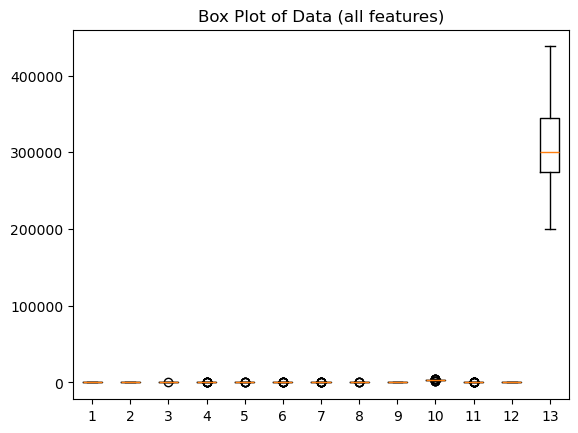

In [76]:
cultivars_temp = cultivars_unified_df.drop(['Cultivar'], axis = 1)  #we drop the non-numerical column - 'Cultivar'
#print(cultivars_temp.head())
plt.boxplot(cultivars_temp, whis = 1.5) #whis factor at default value: 1.5
plt.title('Box Plot of Data (all features)')
plt.show()

As we can see, the values of the 13th column ('Density per meter/linear') have much larger magnitudes then the ones of the other columns. Let's analyze it separately:


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


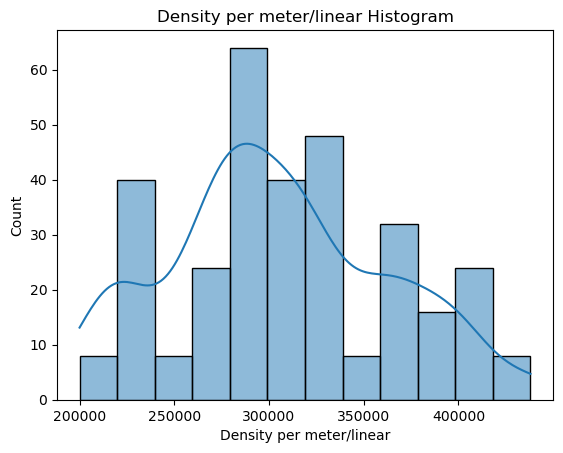

In [100]:
sns.histplot(data=cultivars_temp.iloc[:,12], kde=True)
plt.title('Density per meter/linear Histogram')
plt.show()

As we can see, the values of this feature don't describe an uniform distribution (**oops, so bye bye z-score method**; but we will try it to see the difference between its results and the ones from the IQR method), but we also don't see any outliers. Let's return to the previous plots:

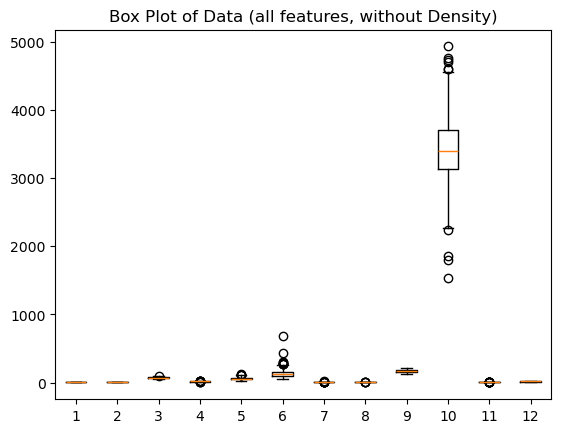

In [74]:
plt.boxplot(cultivars_temp.iloc[:,:12], whis = 1.5)
plt.title('Box Plot of Data (all features, without Density)')
plt.show()

We see a lot of outliers at the column 6 and column 10. Let's analyze their histograms:

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

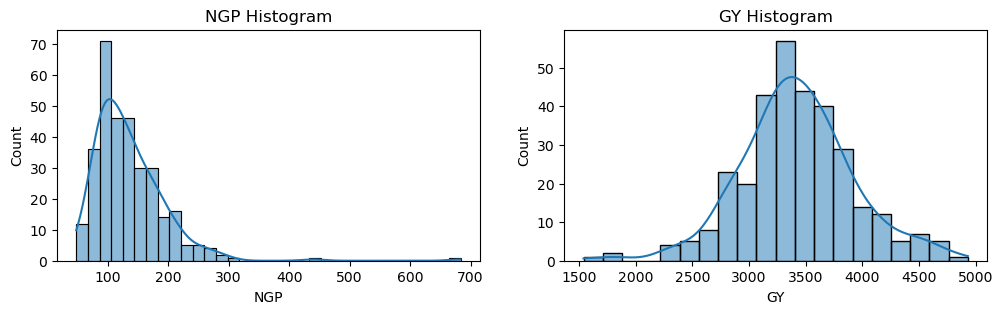

In [75]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1) 
sns.histplot(data=cultivars_temp.iloc[:,5], kde=True)
plt.title('NGP Histogram')

plt.subplot(1, 2, 2) 
sns.histplot(data=cultivars_temp.iloc[:,9], kde=True)
plt.title('GY Histogram')

plt.show()

As we can see, these 2 features follow distribution that is more uniform-ish-er (is that a word?!?) than in the case of the Density histogram. However, we have 2 problems:
- we see that the magnitude of the outliers are significant, especially in case of NGP - number of grains per plant (the last outlier is *brutal* - I am pretty sure that the measurement was done wrong in this case, as the other values for the same season & the same cultivar are 101.8, 96 and 293.73)
- GY is one of the parameters for which we will want to determine the most important factors in Part 2 of this project, so... modifying its values, without having any knowledge in the domain (nope, I don't), isn't recommended

A solution to this would be to use a more conservative outlier identification method, by using a **a whis factor of 3, instead of 1.5**.

Let's identify outliers with both methods (even though we will not use the z-score in the end, it's interesting to analyze both scenarios) and see what results we will obtain:

In [84]:
#IQR method, whis factor = 3
Q1 = cultivars_temp.quantile(0.25)
Q3 = cultivars_temp.quantile(0.75)
IQR = Q3 - Q1
whis_factor = 3.0 #default whis argument is 1.5!!!
lower_bound = Q1 - whis_factor * IQR 
upper_bound = Q3 + whis_factor * IQR
outliers_iqr = cultivars_temp[(cultivars_temp < lower_bound) | (cultivars_temp > upper_bound)]
outliers_iqr_count = outliers_iqr.count().sum() #whis_factor = 1.5 => 63 outliers; whis_factor = 3.0 => 14 outliers

#writing labels of outliers
l_outliers_iqr = []
for row_label, row in outliers_iqr.iterrows():
    for column_label, value in row.items():
        if pd.notna(value):
            l_outliers_iqr.append((row_label, column_label))

#printing outliers
print(f"Outliers identified using IRQ method: {outliers_iqr_count} elements (whis_factor = {whis_factor})")
print("Season | Cultivar | Parameter | Value")
for i in l_outliers_iqr:
    print(f"{cultivars_unified_df.loc[i[0], 'Season']} | {cultivars_unified_df.loc[i[0], 'Cultivar']} | {i[1]} | {cultivars_unified_df.loc[i[0], i[1]]}")


Outliers identified using IRQ method: 14 elements (whis_factor = 3.0)
Season | Cultivar | Parameter | Value
1 | MONSOY 8330I2X | NGL | 4.75
1 | 96R29 IPRO | Maturation group | 6.2
1 | 96R29 IPRO | Maturation group | 6.2
1 | 96R29 IPRO | Maturation group | 6.2
1 | 96R29 IPRO | Maturation group | 6.2
2 | NK 7777 IPRO | NGP | 683.4
2 | NK 7777 IPRO | NGL | 14.86
2 | NK 7777 IPRO | NGL | 6.42
2 | 96R29 IPRO | Maturation group | 6.2
2 | 96R29 IPRO | Maturation group | 6.2
2 | 96R29 IPRO | Maturation group | 6.2
2 | 96R29 IPRO | Maturation group | 6.2
2 | MONSOY M8606I2X | NGP | 440.0
2 | MONSOY M8606I2X | NGL | 4.02


In [88]:
#z-score method, threshold = 3
threshold = 3
z_scores = (cultivars_temp - cultivars_temp.mean()) / cultivars_temp.std()
outliers_z = cultivars_temp[(z_scores > threshold)]
outliers_z_count = outliers_z.count().sum()

#writing labels of outliers
l_outliers_z = []
for row_label, row in outliers_z.iterrows():
    for column_label, value in row.items():
        if pd.notna(value):
            l_outliers_z.append((row_label, column_label))

print(f"Outliers identified using z-score method: {outliers_z_count} elements")
print("Season | Cultivar | Parameter | Value")
for i in l_outliers_z:
    print(f"{cultivars_unified_df.loc[i[0], 'Season']} | {cultivars_unified_df.loc[i[0], 'Cultivar']} | {i[1]} | {cultivars_unified_df.loc[i[0], i[1]]}")


Outliers identified using z-score method: 10 elements
Season | Cultivar | Parameter | Value
1 | NK 7777 IPRO | NS | 9.0
1 | BRASMAX OLIMPO IPRO | IFP | 26.4
1 | LYNDA IPRO | IFP | 25.4
1 | 98R30 CE | GY | 4930.0
2 | NK 7777 IPRO | NGP | 683.4
2 | NK 7777 IPRO | NGL | 14.86
2 | NK 7777 IPRO | NGL | 6.42
2 | NK 8100 IPRO | NS | 9.0
2 | 82HO111 IPRO - HO COXIM IPRO | NLP | 123.0
2 | MONSOY M8606I2X | NGP | 440.0


Using IQR method, we identified 14 outliers, while using z-score method, we identified 10 outliers. HOWEVER, we see that there are a lot of problems with the Maturation group feature -> value = 6.2. Let's see its histogram:

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


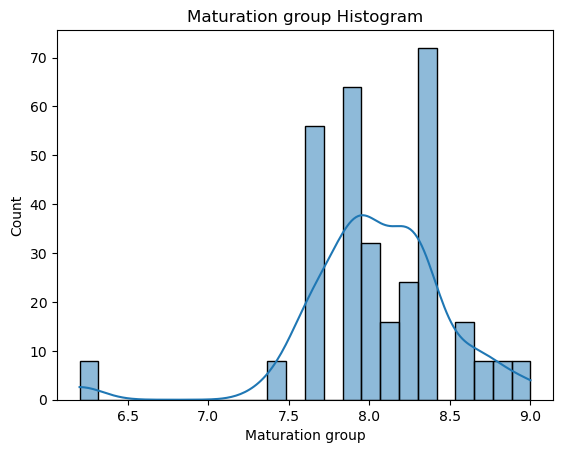

In [104]:
sns.histplot(data=cultivars_temp.iloc[:,10], kde=True)
plt.title('Maturation group Histogram')
plt.show()

Oops, that doesn't look good... That value characterizes the 96R29 IPRO cultivar. So if we change/ normalize it, it will only affect this cultivar. Also, if we don't change the value of this outlier, when we will apply the min-max normalization, this factor will have a significant impact over the min-max scaling, so the answer is clear: be gone outlier! (I know that it's not ideal, but this normalization process must be done - **and you can't do it for some columns and for others not - <font color=red>in this way, you would change the patterns between features!!!</font>**) 

In general, we have 3 options for replacing the values of the outliers (all of them will modify a little bit the distribution):
- *Option 1*: replace outliers with median value of that feature (for non-uniform distributions)
- *Option 2*: replace outliers with mean value of that feature (for uniform distributions)
- *Option 3*: replace outliers with *lower_bound* value if they are smaller then *lower_bound* OR with *upper_bound* value if they are larger then *upper_bound* (clipping effect)

**NOTE 1**: This replacing process should be applied to the same cultivar, for one/ both seasons - you shouldn't compute the mean/ median value for all the cultivars! And because we only have 4/ 8 per cultivars (depending on the chosen period), interpolation isn't recommended.

**NOTE 2**: Only option 3 can change the value of Maturation group parameter.

Let's extract the non-outlier values which correspond to each outlier: 

In [116]:
list_non_outliers = []
for ref in l_outliers_iqr:
    ref_cultivar_name = cultivars_unified_df.loc[ref[0], "Cultivar"]
    temp_non_outliers = []
    for row_label, row in cultivars_unified_df.iterrows():
        if row_label != ref[0] and row.iloc[1] == ref_cultivar_name: #exlude the record of the outlier
            temp_non_outliers.append(row_label)
    list_non_outliers.append(temp_non_outliers) #list_values always has 7 values!

#example of outlier compared to the other values of the same cultivar (different repetitions, different seasons)
idx = 5 #6th outlier
ref = l_outliers_iqr[idx]
print("Cultivar | Season | Value")
print(f"{cultivars_unified_df.loc[ref[0], 'Cultivar']} | {cultivars_unified_df.loc[ref[0], 'Season']} | {cultivars_unified_df.loc[ref[0], ref[1]]} (OUTLIER)")
for i in list_non_outliers[idx]:
    print(f"{cultivars_unified_df.loc[i, 'Cultivar']} | {cultivars_unified_df.loc[i, 'Season']} | {cultivars_unified_df.loc[i, ref[1]]}")


Cultivar | Season | Value
NK 7777 IPRO | 2 | 683.4 (OUTLIER)
NK 7777 IPRO | 1 | 219.2
NK 7777 IPRO | 1 | 176.0
NK 7777 IPRO | 1 | 272.4
NK 7777 IPRO | 1 | 222.53
NK 7777 IPRO | 2 | 101.8
NK 7777 IPRO | 2 | 96.0
NK 7777 IPRO | 2 | 293.73


Above we can see an example of outlier, compared to its correspondent non-outliers. Apart from the big difference between the value of the outlier vs. the values of the non-outliers, we can see that values ranges are different from one season to another. By looking at the other cases, I concluded that *I would use the median value for each season, for each cultivar for that parameter*. Yeah, plot twist: we will not change the values for the Maturation group in the case of 96R29 IPRO cultivar, but this decision was taken by considering all the cases and choosing the best compromise. Also, it isn't mathematically wrong, because I've applied the same reasoning for all the parameters.
Let's now replace the values of the outliers:

In [127]:
outliers_outlier_values = []
for outlier_idx in range(0, len(l_outliers_iqr)):
    temp_list = []
    ref = l_outliers_iqr[outlier_idx][0]
    for i in list_non_outliers[outlier_idx]:
        if i > ref - 4 and i < ref + 4: #cultivars are grouped 4 by 4
            temp_list.append(i) #each time it will have 3 elements
            #print(i)
    
    values_list = []
    ref_label = l_outliers_iqr[outlier_idx][1]
    for i in temp_list:
        values_list.append(cultivars_unified_df.loc[i, ref_label])
    #print(values_list)
    values_list.sort()
    #print(values_list)
    outliers_outlier_values.append(values_list[1]) #median value = element with index 1
        
#replacing outliers with normalized values
#cultivars_copy = cultivars_unified_df #backup
for outlier_idx in range(0, len(l_outliers_iqr)):
    ref = l_outliers_iqr[outlier_idx]
    cultivars_unified_df.loc[ref[0], ref[1]] = outliers_outlier_values[outlier_idx]

cultivars_unified_df.to_csv('data/data_nonNormalized.csv', index=False)

The non-scaled dataframe, with outliers changed was written to the <font color=green>data_nonNormalized.csv</font> file. 

**#1.6) Label Encoding. Min-max feature scaling.**

First, we will encode the name of every cultivar. We can represent them either by assigning a different integer value to all of them or by encoding every name as a one hot representation. The second option will add a lot of dimensionality to the dataframe (40 columns, each with 320 spare data), so we will choose the first solution:

In [154]:
temp = [num for num in range(0, 40) for _ in range(4)]
temp = temp + temp
#print(cultivars_unified_df.head)
cultivars_unified_df['Cultivar'] = temp
#print(cultivars_unified_df.head)

We don't remove the label of the cultivars because, as we will see in Part 2: Data Analysis, the 3 features from *cultivars-description_corrected.ods* can't "represent" alone every cultivar => it also good to include the cultivars names.
Now we apply the min-max scaling to the entire dataframe:

In [156]:
cultivars_copy = cultivars_unified_df
cultivars_minMax = (cultivars_copy - cultivars_copy.min()) / (cultivars_copy.max() - cultivars_copy.min())

cultivars_minMax.to_csv('data/data_Normalized.csv', index=False)

print(cultivars_minMax.head())

   Season  Cultivar  Repetition        PH       IFP       NLP       NGP  \
0     0.0  0.000000    0.000000  0.237288  0.416667  0.758755  0.516283   
1     0.0  0.000000    0.333333  0.233051  0.322917  0.795720  0.584591   
2     0.0  0.000000    0.666667  0.334746  0.520833  0.780156  0.616362   
3     0.0  0.000000    1.000000  0.268432  0.420313  0.778210  0.572399   
4     0.0  0.025641    0.000000  0.711864  0.562500  0.764591  0.497220   

        NGL        NS       MHG        GY  Maturation group  \
0  0.376623  0.558140  0.282662  0.499618               0.5   
1  0.393939  0.790698  0.164493  0.583509               0.5   
2  0.467532  0.744186  0.244547  0.546390               0.5   
3  0.411255  0.697674  0.241061  0.523134               0.5   
4  0.350649  0.813953  0.208343  0.499079               0.5   

   Seeds per meter/linear  Density per meter/linear  
0                0.840336                  0.840336  
1                0.840336                  0.840336  
2       

The min-max scaled dataframe, with outliers changed was written to the <font color=green>data_Normalized.csv</font> file. But we can observe an intresting thing: aren't the seeds and density columns the same? We'll see in just a second... 

**Part 2: Exploratory Data Analysis** (ex 10 - 14)

**#2.1) Delta in MHG and GY from Season 1 to Season 2** (ex 13 -> data_nonNormalized.csv)

To compare those 2 parameters from Season 1 to Season 2, it is more useful to import data from the non-normalized dataframe, which has only the outliers changed. We will treat two cases/ analysis:
- **CASE 1**: for all the cultivars
- **CASE 2**: for each individual cultivar

Now, for the *first case*:

In [5]:
cultivars_df = pd.read_csv('data/data_nonNormalized.csv')

#CASE 1: FOR ALL THE CULTIVARS
MHG_Season1 = cultivars_df.loc[cultivars_df['Season'] == 1, 'MHG']
MHG_Season2 = cultivars_df.loc[cultivars_df['Season'] == 2, 'MHG']
delta_MHG = MHG_Season2.mean() - MHG_Season1.mean() #12.067 => increase

GY_Season1 = cultivars_df.loc[cultivars_df['Season'] == 1, 'GY']
GY_Season2 = cultivars_df.loc[cultivars_df['Season'] == 2, 'GY']
delta_GY = GY_Season2.mean() - GY_Season1.mean() #-19.797 => decrease

print(MHG_Season2.mean(), MHG_Season1.mean(), delta_MHG)
print(GY_Season2.mean(), GY_Season1.mean(), delta_GY)

174.3558125 162.2888125 12.067000000000007
3408.6551508499992 3428.4524375 -19.797286650000842


Conclusions:
- **MHG**: Season to season, as an average for all the cultivars, we have an <font color = green>increase</font> of 12.067 for the thousand seed weight parameter, meaning a relative **increase of aprox. 7.435%**
- **GY**: Season to season, as an average for all the cultivars, we have a <font color=red>decrease</font> of 19.797 for the grain yield parameter, meaning a relative **decrease of aprox. 0.577%**

Now, let's move to the *second case*:

In [6]:
#CASE 2: FOR THE SAME CULTIVARS
#sort = False keeps the same order from cultivars_db
cultivar_grouped = cultivars_df.groupby('Cultivar', sort = False)
#cultivar_grouped.first()
#cultivar_grouped.get_group('NEO 760 CE')

delta_list = []
for group_name, group_data in cultivar_grouped:
    MHG_Season1_temp = group_data.loc[group_data['Season'] == 1, 'MHG'].mean()
    MHG_Season2_temp = group_data.loc[group_data['Season'] == 2, 'MHG'].mean()
    MHG_delta = MHG_Season2_temp - MHG_Season1_temp
    
    GY_Season1_temp = group_data.loc[group_data['Season'] == 1, 'GY'].mean()
    GY_Season2_temp = group_data.loc[group_data['Season'] == 2, 'GY'].mean()
    GY_delta = GY_Season2_temp - GY_Season1_temp
    
    dict_delta = {'Cultivar Name': group_name, 'Delta MHG': MHG_delta, 'Delta GY': GY_delta}
    delta_list.append(dict_delta)

cultivar_delta = pd.DataFrame(delta_list)
print(cultivar_delta)

                   Cultivar Name  Delta MHG     Delta GY
0                     NEO 760 CE    13.2700  -152.073678
1                      MANU IPRO    15.4300    59.949741
2           77HO111I2X - GUAPORÉ     7.3425   -25.341063
3                   NK 7777 IPRO     6.4700  -319.852184
4           GNS7900 IPRO - AMPLA    19.9525   425.107701
5                  LTT 7901 IPRO     8.9650   177.925259
6             BRASMAX BÔNUS IPRO    27.1100  -924.302097
7                     97Y97 IPRO    10.3125   200.636379
8            BRASMAX OLIMPO IPRO    11.5625  -783.323247
9                     LYNDA IPRO     4.5600  -732.351782
10                  NK 8100 IPRO     5.0900   180.468219
11  82HO111 IPRO - HO COXIM IPRO     7.6225   334.871580
12                 83IX84RSF I2X    16.9050  -572.899626
13          ADAPTA LTT 8402 IPRO    18.2025 -1678.402327
14                      98R30 CE    11.3650 -1565.139512
15                FORTALEZA IPRO     1.0100  -923.797931
16                MONSOY 8330I2

Conclusions:
- **MHG (<font color = green>largest increase</font>)**: Season to season, for the NEO 790 IPRO cultivar, we have an <font color = green>increase</font> of 46.810 for the thousand seed weight parameter, meaning a relative (to the 4 repetitions) **increase of aprox. 32.387%**
- **MHG (<font color=red>largest decrease</font>)**: Season to season, for the FTR 4288 IPRO cultivar, we have an <font color = red>decrease</font> of 12.795 for the thousand seed weight parameter, meaning a relative (to the 4 repetitions) **decrease of aprox. 8.415%**
- **GY (<font color = green>largest increase</font>)**: Season to season, for the 79I81RSF IPRO cultivar, we have a <font color=green>increase</font> of 1143.882 for the grain yield parameter, meaning a relative (to the 4 repetitions) **increase of aprox. 38.709%**
- **GY (<font color = red>largest decrease</font>)**: Season to season, for the ADAPTA LTT 8402 IPRO cultivar, we have a <font color=red>decrease</font> of 1678.402 for the grain yield parameter, meaning a relative (to the 4 repetitions) **decrease of aprox. 36.597%**

**#2.2) Factors determining MHG and GY**

**#2.2.1) Correlation coefficients**

Computing the correlation matrix is useful in finding linear relationships between several features. For this, we used the the min-max normalized set of data, giving us the following results:

Maximum correlation coefficient:  0.9983975807787351
Minimum correlation coefficient:  -0.6014667079321143


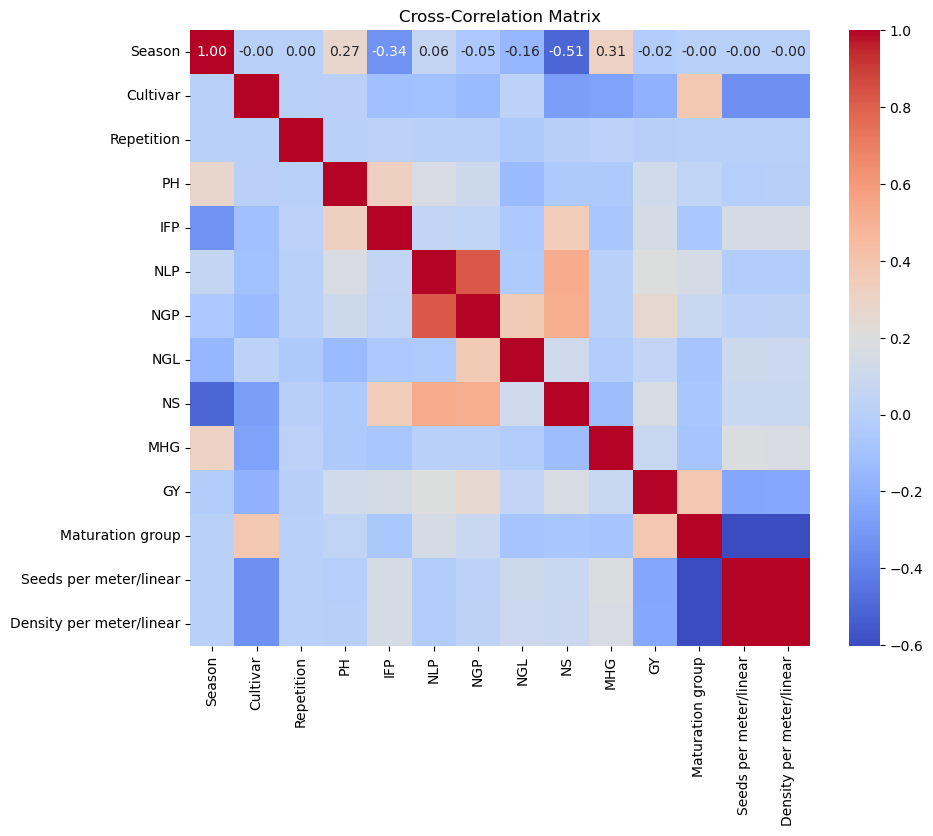

In [8]:
cultivars_df = pd.read_csv('data/data_Normalized.csv')

correlation_matrix = cultivars_df.corr()
M = correlation_matrix.unstack()
print("Maximum correlation coefficient: ", max(M[M != 1])) #the main diagonal is always 1
print("Minimum correlation coefficient: ", min(M))

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Cross-Correlation Matrix')
plt.show()

A plethora of conclusions can be drawn through the analysis of the heatmap above (**without analyzing MHG and GY**):
- We have an almost maximum positive correlation (0.998) between the 'Seeds per meter/linear' column and the 'Density per meter/linear'. When analyzing data further, we <font color=red>**will remove the 'Density per meter/linear' column**</font>, because of the redundancy that it adds to the entire dataframe. Roughly, the formula between these 2 values is: **Density = Seeds * 20000**
- We have a strong positive correlation (0.825) between 'NGP' (number of grains per plant) and 'NLP' (number of legumes per plant). Because of this strong correlation, we will also <font color=red>**remove the 'NGP' column**</font>, because of its redundancy.
- We have a strong negative correlation (-0.601) between the 'Maturation group' and the 'Seeds per meter/linear' column, meaning that <font color=green>**all 3 features from the cultivars-description_corrected.ods file have a dependency for each other**</font>
- However, we have a relatively weak positive correlation between the Cultivar name and 'Maturation group' (0.376) AND a relatively weak negative correlation between the Cultivar name and the 'Seeds per meter/ linear' (-0.345) => **the Seeds and Maturation features aren't "strong enough to represent the Cultivar label** => <font color=green>**it is also recommended to use the Cultivar column in the prediction tasks**</font>
- We have a moderate negative correlation (-0.506) between NS (number of stems) and season number (wanted to delete this column in a first instance...)
- We have a moderate positive correlation between NS and NLP (0.522) AND NS and NGP (0.517), underlining again the need to delete one of those 2 columns 

Now, by looking at the correlation matrix, the MHG and GY features are having the maximum correlation coefficients (absolute values) with:
- **MHG: <font color=green>Season number (0.308), Cultivar name (-0.258), Seeds per meter/ linear (0.183), NS (-0.129)</font>**
- **GY: <font color=green>Maturation group (0.382), NGP (0.260), Seeds per meter/ linear (-0.240), NS (0.167)</font>**

GY is better "represented" by the Maturation group compared to the relation between MHG and Season number, although the difference is pretty small. Even if the correlations are pretty weak, **<font color=green>the features from above can be considered to have a consistent role in influencing the values of MHG and GY</font>**, because the correlation matrix computes only the relation between every two features, so it doesn't help us see the patterns between several feature at the same time. However, one should note that even if we obtained large magnitude correlation coefficient for some of the features, it doesn't have a causality meaning!!! For this, we need to have an extensive domain knowledge and maybe, more data.
But we can further continue the analysis by using three regressor:
- **Multiple linear regressor**
- **Random Forest regressor**
- **Gradient Boosting Machine**

Each of these regressor algorithms can offer us more ways to test the deterministic role of every feature to/ for MHG and GY. Meanwhile, *we can also test the models to see which one is better suited for the prediction of MHG, which will be done in Part 3*.

**#2.2.2) Multiple linear regression** (cross-validation mean squared error, coefficients, permutation feature importance)

MLR is used to analyze the relationship between multiple independent variables and a single dependent variable. By examining the model's <font color =green>coefficients</font> (evert coefficient is associated with each independent variable), we can assess their relative importance to **MHG**/ **GY**, depending on the case. Also, we will compute the <font color=green>permutation feature importance</font> for each feature (this method involves randomly shuffling the values of each feature and observing the resulting change in model performance: the higher the value of PFI, the greater importance the feature has).

To see how well the model fits the data, we will as reference parameter the **negative mean square error**, while also applying the <font color=green>kfold cross-validation technique</font> (we will use the default hyperparameters of each model, and the "winner" will be optimized in Part 3) - in this way, we can analyze the performance across multiple folds (NOTE: it must be applied only to the training set!)

In [74]:
cultivars_df = pd.read_csv('data/data_Normalized.csv')
cross_validation = KFold(n_splits=5, shuffle=True, random_state=42) #kfold cross-validation
cv_list = []
perm_list = []

#print(cultivars_df.describe())
#MHG std -> 0.22; GY std -> 0.14

**#2.2.2.1) Multiple linear regression - analysis for MHG (std = 0.22)**

In [76]:
x = cultivars_df.drop(['MHG', 'Density per meter/linear', 'NGP'], axis = 1) 
y = cultivars_df['MHG']  #target feature

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#selecting regression model
model = LinearRegression()

#applying kfold cross-validation
cv_scores = cross_val_score(model, x_train, y_train, cv=cross_validation, scoring='neg_mean_squared_error')
#cv_scores = cross_val_score(model, x_train, y_train, cv=kf, scoring='r2')
cv_scores = -cv_scores

#training the regression model
model.fit(x_train, y_train)

#computing permutation feature importance
perm_importance = permutation_importance(model, x_train, y_train, n_repeats=10, random_state=42)
dict_perm = dict(zip(x_train.columns, perm_importance['importances_mean']))

#evaluating the model
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)

coefficients = pd.DataFrame({'Feature': x.columns, 'Coefficient': model.coef_})

In [77]:
#saving model to pickle file
fp = 'models/MHG_MLR_unoptimzed.pkl'
with open(fp, 'wb') as f:
    pickle.dump(model, f)

print("Model saved to", fp)

Model saved to models/MHG_MLR_unoptimzed.pkl


In [78]:
print("Cross-validation MSE scores:", cv_scores)
print("Mean MSE (cross-validation - MLR MHG):", cv_scores.mean()) #consistent scores

sorted_dict = {k: v for k, v in sorted(dict_perm.items(), key=lambda item: -abs(item[1]))}
print("\nPermutation feature importance:", sorted_dict)

print("\nMean Squared Error (after_prediction): ", mse)

print("\nResulted coefficients for the model")
print(coefficients)

Cross-validation MSE scores: [0.0542823  0.04103913 0.03507176 0.03450802 0.04740966]
Mean MSE (cross-validation - MLR MHG): 0.04246217421272118

Permutation feature importance: {'Season': 0.2576093332646202, 'PH': 0.09474316787024469, 'Cultivar': 0.06706571834090189, 'Seeds per meter/linear': 0.048916223709433035, 'GY': 0.02321728215645179, 'IFP': 0.006887719864858133, 'NS': 0.004821996112663285, 'Repetition': 0.0037281226756506803, 'Maturation group': 0.0023207996627114813, 'NGL': 0.00033786539443049214, 'NLP': -0.00021869036883568339}

Mean Squared Error (after_prediction):  0.04055145329743656

Resulted coefficients for the model
                   Feature  Coefficient
0                   Season     0.157039
1                 Cultivar    -0.141765
2               Repetition     0.024373
3                       PH    -0.259426
4                      IFP     0.087017
5                      NLP    -0.014320
6                      NGL    -0.018320
7                       NS    -0.06169

Obtained result:
- **Cross-validation mean MSE score**: 0.0425
- **Model coefficients**: PH (-0.259), GY (0.166), Season number (0.157), Seeds per meter/ linear (0.146), Cultivar name (-0.141)
- **Permutation feature importance**: Season number (0.258), PH (0.095), Cultivar name (0.067), Seeds per meter/linear (0.049), GY (0.023)

**#2.2.2.2) Multiple linear regression - analysis for GY (std = 0.14)**

In [79]:
x = cultivars_df.drop(['GY', 'Density per meter/linear', 'NGP'], axis = 1) 
y = cultivars_df['GY']  #target feature

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = LinearRegression()

cv_scores = cross_val_score(model, x_train, y_train, cv=cross_validation, scoring='neg_mean_squared_error')
cv_scores = -cv_scores

model.fit(x_train, y_train)

perm_importance = permutation_importance(model, x_train, y_train, n_repeats=10, random_state=42)
dict_perm = dict(zip(x_train.columns, perm_importance['importances_mean']))

y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)

coefficients = pd.DataFrame({'Feature': x.columns, 'Coefficient': model.coef_})

In [80]:
fp = 'models/GY_MLR_unoptimzed.pkl'
with open(fp, 'wb') as f:
    pickle.dump(model, f)

print("Model saved to", fp)

Model saved to models/GY_MLR_unoptimzed.pkl


In [81]:
print("Cross-validation MSE scores:", cv_scores)
print("Mean MSE (cross-validation - MLC GY):", cv_scores.mean()) #consistent scores

sorted_dict = {k: v for k, v in sorted(dict_perm.items(), key=lambda item: -abs(item[1]))}
print("\nPermutation feature importance:", sorted_dict)

print("\nMean Squared Error (after_prediction): ", mse)

print("\nResulted coefficients for the model")
print(coefficients)

Cross-validation MSE scores: [0.01999516 0.01793752 0.01591863 0.01561133 0.01206851]
Mean MSE (cross-validation - MLC GY): 0.016306229660336

Permutation feature importance: {'Maturation group': 0.35402457457175696, 'Cultivar': 0.2290189204009479, 'Seeds per meter/linear': 0.06461417267476607, 'MHG': 0.020228742171029324, 'PH': 0.017364997989410914, 'NGL': 0.017294184962788763, 'NS': 0.01695908996889638, 'IFP': 0.011518534797863179, 'Season': 0.002557236388453732, 'Repetition': 0.0012949595256393498, 'NLP': 0.000275890627895492}

Mean Squared Error (after_prediction):  0.015903870353581914

Resulted coefficients for the model
                   Feature  Coefficient
0                   Season     0.008813
1                 Cultivar    -0.175185
2               Repetition     0.012780
3                       PH     0.075598
4                      IFP     0.072912
5                      NLP     0.015720
6                      NGL     0.100757
7                       NS     0.089508
8    

Obtained result:
- **Cross-validation mean MSE score**: 0.0163
- **Model coefficients**: Maturation group (0.393), Cultivar name (-0.175), Seeds per meter/ linear (-0.106), NGL (0.101), NS (0.089)
- **Permutation feature importance**: Maturation group (0.354), Cultivar name (0.229), Seeds per meter/ linear (0.065), MHG (0.020), PH (0.017)

**CONCLUSIONS (Multiple linear regression)**:
- <font color=green>**MHG -> the situation is not so simple for this parameter, but three possible well-suited descriptors for it can be the Season number, Cultivar name and the Seeds per meter features**</font>; other possible descriptors: PH, GY
- <font color=green>**GY -> seems like 3 good descriptors for this parameter are Maturation group, Cultivar Name and Seeds per meter/ linear**</font> (two of them also shown a good correlation coefficient with GY)
- **MHG -> we have and cross-validation mean MSE score of 0.0425 for a std of 0.22 (MHG)**
- **GY -> we have and cross-validation mean MSE score of 0.0163 for a std of 0.14 (GY)**

**#2.2.3) Random Forest regressor** (cross-validation mean squared error, **Gini importance**, permutation feature importance)

blablabla

In [82]:
cultivars_df = pd.read_csv('data/data_Normalized.csv')
cross_validation = KFold(n_splits=5, shuffle=True, random_state=42) #kfold cross-validation
cv_list = []
perm_list = []

#print(cultivars_df.describe())
#MHG std -> 0.22; GY std -> 0.14

**#2.2.3.1) Random Forest regressor - analysis for MHG (std = 0.22)**

In [83]:
x = cultivars_df.drop(['MHG', 'Density per meter/linear', 'NGP'], axis = 1) 
y = cultivars_df['MHG']  #target feature

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(random_state=42)

cv_scores = cross_val_score(model, x_train, y_train, cv=cross_validation, scoring='neg_mean_squared_error')
cv_scores = -cv_scores

model.fit(x_train, y_train)

perm_importance = permutation_importance(model, x_train, y_train, n_repeats=10, random_state=42)
dict_perm = dict(zip(x_train.columns, perm_importance['importances_mean']))

#Gini importances
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': importances})

y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)


In [56]:
#saving model to pickle file
fp = 'models/MHG_RFR_unoptimzed.pkl'
with open(fp, 'wb') as f:
    pickle.dump(model, f)

print("Model saved to", fp)

Model saved to models/MHG_RFR_unoptimzed.pkl


In [85]:
print("Cross-validation MSE scores:", cv_scores)
print("Mean MSE (cross-validation - RFR MHG):", cv_scores.mean()) #consistent scores

sorted_dict = {k: v for k, v in sorted(dict_perm.items(), key=lambda item: -abs(item[1]))}
print("\nPermutation feature importance:", sorted_dict)

print("\nMean Squared Error (after_prediction): ", mse)

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("\nResulted Gini importances:")
print(feature_importance_df)

Cross-validation MSE scores: [0.01483771 0.01257531 0.0116486  0.01254708 0.02307626]
Mean MSE (cross-validation - RFR MHG): 0.014936995313099288

Permutation feature importance: {'Cultivar': 0.48661283506604464, 'Seeds per meter/linear': 0.3220884613769178, 'GY': 0.24813988261659628, 'Maturation group': 0.16147311808012227, 'PH': 0.09767981474831097, 'NS': 0.06177283978391958, 'Season': 0.05976056819136812, 'IFP': 0.04547153837932485, 'NLP': 0.031158726138924054, 'NGL': 0.02197920710491713, 'Repetition': 0.0056809085333480395}

Mean Squared Error (after_prediction):  0.009907586510924313

Resulted Gini importances:
                   Feature  Importance
1                 Cultivar    0.241116
8                       GY    0.154384
10  Seeds per meter/linear    0.135232
9         Maturation group    0.128306
3                       PH    0.082368
7                       NS    0.066782
4                      IFP    0.062585
5                      NLP    0.043456
0                   Seaso

Obtained result:
- **Cross-validation mean MSE score**: 0.0149
- **Permutation feature importance**: Cultivar name (0.486), Seeds per meter/ linear (0.322), GY (0.248), Maturation group (0.161), PH (0.098)
- **Gini importances**: Cultivar name (0.241), GY (0.154), Seeds per meter/ linear (0.135), Maturation group (0.128), PH (0.082)

**#2.2.3.2) Random Forest regressor - analysis for GY (std = 0.14)**

In [86]:
x = cultivars_df.drop(['GY', 'Density per meter/linear', 'NGP'], axis = 1) 
y = cultivars_df['GY']  #target feature

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(random_state=42)

cv_scores = cross_val_score(model, x_train, y_train, cv=cross_validation, scoring='neg_mean_squared_error')
cv_scores = -cv_scores

model.fit(x_train, y_train)

perm_importance = permutation_importance(model, x_train, y_train, n_repeats=10, random_state=42)
dict_perm = dict(zip(x_train.columns, perm_importance['importances_mean']))

importances = model.feature_importances_ #Gini feature importance
feature_importance_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': importances})

y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)


In [87]:
#saving model to pickle file
fp = 'models/GY_RFR_unoptimzed.pkl'
with open(fp, 'wb') as f:
    pickle.dump(model, f)

print("Model saved to", fp)

Model saved to models/GY_RFR_unoptimzed.pkl


In [88]:
print("Cross-validation MSE scores:", cv_scores)
print("Mean MSE (cross-validation - RFR GY):", cv_scores.mean()) #consistent scores

sorted_dict = {k: v for k, v in sorted(dict_perm.items(), key=lambda item: -abs(item[1]))}
print("\nPermutation feature importance:", sorted_dict)

print("\nMean Squared Error (after_prediction): ", mse)

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("\nResulted Gini importances:")
print(feature_importance_df)

Cross-validation MSE scores: [0.00797606 0.00719459 0.00737742 0.00765342 0.00529808]
Mean MSE (cross-validation - RFR GY): 0.007099914456955882

Permutation feature importance: {'Maturation group': 0.5507011194652621, 'MHG': 0.24053659738618713, 'Cultivar': 0.19278425554612416, 'Season': 0.13495609570207023, 'NS': 0.11718008800144102, 'Seeds per meter/linear': 0.09597601227917832, 'IFP': 0.0759098966937394, 'NLP': 0.05259659172032151, 'NGL': 0.051078321155546405, 'PH': 0.03738663130028417, 'Repetition': 0.004644960654435459}

Mean Squared Error (after_prediction):  0.0069540129888686205

Resulted Gini importances:
                   Feature  Importance
8                      MHG    0.168183
9         Maturation group    0.156732
1                 Cultivar    0.123402
10  Seeds per meter/linear    0.111197
7                       NS    0.108210
4                      IFP    0.080055
0                   Season    0.074718
5                      NLP    0.060276
6                      NGL

Obtained result:
- **Cross-validation mean MSE score**: 0.0080
- **Permutation feature importance**: Maturation group (0.551), MHG (0.240), Cultivar name (0.193), Season number (0.135), NS (0.117)
- **Gini importances**: MHG (0.168), Maturation group (0.157), Cultivar name (0.123), Seeds per meter/ linear (0.111), NS (0.108)

**CONCLUSIONS (Random Forest regressor)**:
- <font color=green>**MHG -> good descriptors: Cultivar name, Seeds per meter/ linear, Maturation group, PH (this time, it was easier to identify them - consistent descriptors scores/ order)**</font>; another possible descriptor: GY
- <font color=green>**GY -> again, Maturation group, Cultivar Name and Seeds per meter/ linear can be used to describe in a meaningful way this parameter**</font>; another possible descriptor: MHG
- **MHG -> we have and cross-validation mean MSE score of 0.0149 for a std of 0.22 (MHG), aprox 3 times smaller then the one of the Multiple Linear Regression**
- **GY -> we have and cross-validation mean MSE score of 0.0080 for a std of 0.14 (GY), aprox 2 times smaller then the one of the Multiple Linear Regression**

**#2.2.4) Gradient Boosting Machine** (cross-validation mean squared error, Gini importance, permutation feature importance)

insert description

In [89]:
cultivars_df = pd.read_csv('data/data_Normalized.csv')
cross_validation = KFold(n_splits=5, shuffle=True, random_state=42) #kfold cross-validation
cv_list = []
perm_list = []

#print(cultivars_df.describe())
#MHG std -> 0.22; GY std -> 0.14

**#2.2.4.1) Gradient Boosting Machine - analysis for MHG (std = 0.22)**

In [90]:
x = cultivars_df.drop(['MHG', 'Density per meter/linear', 'NGP'], axis = 1) 
y = cultivars_df['MHG']  #target feature

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model = GradientBoostingRegressor(random_state=42)

cv_scores = cross_val_score(model, x_train, y_train, cv=cross_validation, scoring='neg_mean_squared_error')
cv_scores = -cv_scores

model.fit(x_train, y_train)

perm_importance = permutation_importance(model, x_train, y_train, n_repeats=10, random_state=42)
dict_perm = dict(zip(x_train.columns, perm_importance['importances_mean']))

importances = model.feature_importances_ #Gini feature importance
feature_importance_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': importances})

y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)

In [91]:
#saving model to pickle file
fp = 'models/MHG_GBM_unoptimzed.pkl'
with open(fp, 'wb') as f:
    pickle.dump(model, f)

print("Model saved to", fp)

Model saved to models/MHG_GBM_unoptimzed.pkl


In [92]:
print("Cross-validation MSE scores:", cv_scores)
print("Mean MSE (cross-validation - GBM MHG):", cv_scores.mean()) #consistent scores

sorted_dict = {k: v for k, v in sorted(dict_perm.items(), key=lambda item: -abs(item[1]))}
print("\nPermutation feature importance:", sorted_dict)

print("\nMean Squared Error (after_prediction): ", mse)

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("\nResulted Gini importances:")
print(feature_importance_df)

Cross-validation MSE scores: [0.01384786 0.01580321 0.01005476 0.01089585 0.01640052]
Mean MSE (cross-validation - GBM MHG): 0.01340044165723379

Permutation feature importance: {'Cultivar': 0.3636777053424236, 'Maturation group': 0.24677735787409208, 'Seeds per meter/linear': 0.21907138962250414, 'GY': 0.21046844197661135, 'Season': 0.07762899538991914, 'PH': 0.06479912933220301, 'NS': 0.0641202726726779, 'IFP': 0.043867128567816174, 'NGL': 0.03190833920727043, 'NLP': 0.025905699145814733, 'Repetition': 0.00573453411798146}

Mean Squared Error (after_prediction):  0.010258303309314848

Resulted Gini importances:
                   Feature  Importance
1                 Cultivar    0.291127
9         Maturation group    0.177704
8                       GY    0.147718
10  Seeds per meter/linear    0.133719
3                       PH    0.062377
7                       NS    0.051024
4                      IFP    0.041147
0                   Season    0.040305
6                      NGL  

Obtained result:
- **Cross-validation mean MSE score**: 0.0134
- **Permutation feature importance**: Cultivar name (0.364), Maturation group (0.247), Seeds per meter/ linear (0.219), GY (0.210), Season number (0.078)
- **Gini importances**: Cultivar name (0.291), Maturation group (0.178), GY (0.147), Seeds per meter/ linear (0.134), PH (0.062)

**#2.2.4.2) Gradient Boosting Machine  - analysis for GY (std = 0.14)**

In [93]:
x = cultivars_df.drop(['GY', 'Density per meter/linear', 'NGP'], axis = 1) 
y = cultivars_df['GY']  #target feature

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model = GradientBoostingRegressor(random_state=42)

cv_scores = cross_val_score(model, x_train, y_train, cv=cross_validation, scoring='neg_mean_squared_error')
cv_scores = -cv_scores

model.fit(x_train, y_train)

perm_importance = permutation_importance(model, x_train, y_train, n_repeats=10, random_state=42)
dict_perm = dict(zip(x_train.columns, perm_importance['importances_mean']))

importances = model.feature_importances_ #Gini feature importance
feature_importance_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': importances})

y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)

In [94]:
#saving model to pickle file
fp = 'models/GY_GBM_unoptimzed.pkl'
with open(fp, 'wb') as f:
    pickle.dump(model, f)

print("Model saved to", fp)

Model saved to models/GY_GBM_unoptimzed.pkl


In [95]:
print("Cross-validation MSE scores:", cv_scores)
print("Mean MSE (cross-validation - GBM GY):", cv_scores.mean()) #consistent scores

sorted_dict = {k: v for k, v in sorted(dict_perm.items(), key=lambda item: -abs(item[1]))}
print("\nPermutation feature importance:", sorted_dict)

print("\nMean Squared Error (after_prediction): ", mse)

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("\nResulted Gini importances:")
print(feature_importance_df)

Cross-validation MSE scores: [0.00877275 0.00683981 0.01038914 0.00624737 0.00647337]
Mean MSE (cross-validation - GBM GY): 0.007744489329157207

Permutation feature importance: {'Maturation group': 0.4782279522446634, 'Cultivar': 0.16905664888666957, 'MHG': 0.15242114119660038, 'NS': 0.14348148044200443, 'IFP': 0.12041437221989484, 'Season': 0.08719923175430258, 'Seeds per meter/linear': 0.05879820133175033, 'PH': 0.05045317118382812, 'NGL': 0.03844437992221892, 'NLP': 0.03624606359753577, 'Repetition': 0.006718829227942291}

Mean Squared Error (after_prediction):  0.009539097033369123

Resulted Gini importances:
                   Feature  Importance
9         Maturation group    0.199810
8                      MHG    0.165923
1                 Cultivar    0.144336
7                       NS    0.118504
0                   Season    0.099831
4                      IFP    0.075826
10  Seeds per meter/linear    0.070676
6                      NGL    0.046299
5                      NLP 

Obtained result:
- **Cross-validation mean MSE score**: 0.0077
- **Permutation feature importance**: Maturation group (0.478), Cultivar name (0.169), MHG (0.152), NS (0.143), IFP (0.120)
- **Gini importances**: Maturation group (0.199), MHG (0.166), Cultivar name (0.144), NS (0.118), Season number (0.099)

**CONCLUSIONS (Gradient Boosting Machine)**:
- <font color=green>**MHG -> good descriptors: Cultivar name, Maturation group, Seeds sper meter/ linear**</font>; another possible regressor:GY
- <font color=green>**GY -> good descriptors: Maturation group, Cultivar name, MHG**</font>; another possible descriptor: MHG, NS
- **MHG -> we have and cross-validation mean MSE score of 0.0134 for a std of 0.22 (MHG), smaller then the one of Random Forest Regressor**
- **GY -> we have and cross-validation mean MSE score of 0.0077 for a std of 0.14 (GY), smaller then the one of the Random Forest Regressor**

<font color=blue>**#2.2) Factors determining MHG and GY - CONCLUSIONS** </font>

- We've obtained the smallest main squared error for Gradient Boosting Machine => <font color=green>**it seems like GBM is the best suitable for our data**</font> (although other tests should also be performed, the timeframe for this project is too small...)
- After computing the correlation matrix and the feature importances metrics, we can say that the most important descriptors for <font color=green>**MHG are: Cultivar name, Seeds per meter/ linear, Maturation group and Season number**</font>
- For the other case,  the most important descriptors for <font color=green>**GY are: Maturation group (very important), Seeds per meter/ linear, NS, Cultivar Name**</font>
- Three of the main descriptors written above for MHG and GY coincide
- Also, while using all the regressors, **we found that there is a little dependency between MHG and GY**
- **IT SSEEMS LIKE IT WAS A GOOD IDEA TO INCLUDE THE DATA FROM THE SECOND TABLE, cultivars-description_corrected.ods!**
- From my point of view, there is small problem in the fact that we found Cultivar name a main descriptor for both MHG and GY: as we said previously, there isn't any descriptor/ combination of descriptors that can fully describe every cultivar => <font color=red>**OTHER DESCRIPTORS SHOULD BE ALSO INTRODUCED IN THE TABLE(S) TO BETTER PREDICT MHG AND GY**</font>